<a href="https://colab.research.google.com/github/kodiakpony/datakit-housing-fall-2024/blob/main/challenge-3/FL/DataKindHousingChallenge3Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is looking at the DataKind Housing Challenge #3 "Getting Started" questions.  Feel free to correct/advise/suggest/improve!  

This is still very much under construction

I am comparing the census tracts that belong to the:
* the HUD Low Income Housing Tax Credit (LIHTC) program  
* HUD Opportunity Zones Program
* Dept of Treasury CDFI Fund Investment Areas

These are indicated by the following columns in the dataset
* qct
* opzone
* investment_areas
* economic_distress_pop_agg

First I look at the overlap in the sets of geoids belonging to each program, using cross tabulations and venn diagrams. And Folium marker and chloropleth maps in the geospatial visualizations section.

Then I start looking at population distributions within each set. Right now just racial demographics. I visualize these with interactive plotly radial plots, which seemed like a good idea at the time but don't seem to show up when viewing the file in GitHub.

This is still using the original DataKind dataset for this challenge, with < 2000 rows. Once there is an updated dataset available I'll start using that.

# Background

https://github.com/datakind/datakit-housing-fall-2024/discussions/3


Create an understanding of where affordable housing development is likely to be funded or otherwise incentivized. There are several federal government supported programs that offer financial support for affordable housing construction. Starting with three programs, the HUD Low Income Housing Tax Credit (LIHTC) program Qualified Census Tracts, the HUD Opportunity Zones Program Census Tracts, and the Dept of Treasury CDFI Fund Investment Areas. Data from these three programs is contained within the EODatascape. Using this data, create an understanding of housing construction opportunities for financial support at a Census tract level.

...

This “getting started” analysis should help answer the following questions:

* **Do the geographies for these three programs overlap?**
* Do the geographies align to high population density?
* Does the population breakdown shift by geography?
* Are the areas of incentive in areas of potential environmental hazard?
* Analysis insights and questions: What surprised you from this analysis? What are some limitations of the analysis? What are ways to extend the work?






# Setup

*Must execute this first so can run other code blocks!*


In [23]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2,venn2_circles,venn3, venn3_circles
import seaborn as sns
import zipfile
import requests, io
import plotly.express as px

import numpy as np
#import contextily as ctx
import geopandas as gpd
import os
import folium
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [24]:
# Read housing dataset into Panda dataframe df

url = 'https://github.com/datakind/datakit-housing-fall-2024/releases/download/v1.0/housing-data.zip'
filename = "housing-data/FL/data_1-FL.csv"

r = requests.get(url)

with zipfile.ZipFile(io.BytesIO(r.content)) as myzip:
    with myzip.open(filename) as myfile:
        df = pd.read_csv(myfile)
df

,geoid,geoid_year,state,county,state_fips_code,county_fips_code,b19083_001e,b19083_001m,economic_distress_pop_agg,economic_distress_simple_agg,...,num_mortgage_originated,number_of_sba504_loans,number_of_sba7a_loans,qct,s2503_c01_024e,s2503_c01_024m,s2503_c03_024e,s2503_c03_024m,s2503_c05_024e,s2503_c05_024m
0,12001000400,2020,12,1,12,1,0.3928,0.0724,YES,YES,...,117.0,5.0,5.0,0,961,110,909,67,1297,405
1,12001000806,2020,12,1,12,1,0.5466,0.0649,YES,YES,...,6.0,1.0,NaN,1,960,38,-666666666,-222222222,971,43
2,12001000901,2020,12,1,12,1,0.3641,0.0878,YES,YES,...,NaN,NaN,NaN,1,778,21,-666666666,-222222222,776,20
3,12001001203,2020,12,1,12,1,0.3662,0.0894,YES,YES,...,79.0,1.0,NaN,0,1255,177,882,99,1587,95
4,12001001514,2020,12,1,12,1,0.5686,0.0634,YES,YES,...,2.0,1.0,NaN,1,1460,226,733,58,1482,183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,12033003506,2020,12,33,12,33,0.4322,0.0543,NO,NO,...,159.0,NaN,NaN,1,1364,214,1448,277,1238,315
1601,12033003800,2020,12,33,12,33,0.4402,0.0756,NO,NO,...,121.0,NaN,NaN,0,911,206,781,252,1073,132
1602,12033003900,2020,12,33,12,33,0.4109,0.0580,NO,NO,...,98.0,NaN,2.0,0,808,179,824,99,622,255
1603,12035060206,2020,12,35,12,35,0.4620,0.0618,YES,YES,...,184.0,13.0,4.0,0,587,119,495,127,974,127


Create smaller dataset with just columns relevant to this analysis, with "YES" "NO" converted to "1" "0"

In [25]:
# Create smaller dataframe df2 with just columns relevant to this analysis, with "YES" "NO" converted to "1" "0"
df2 = pd.concat([
                df.geoid,
                df.county,
                df.opzone,
                df.investment_areas.replace({"YES":1,"NO":0}),
                df.qct,
                df.economic_distress_pop_agg.replace({"YES":1,"NO":0}),
                df.economic_distress_simple_agg.replace({"YES":1,"NO":0})
                ], axis=1)

df2

<ipython-input-25-4c9adda2065e>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.investment_areas.replace({"YES":1,"NO":0}),
<ipython-input-25-4c9adda2065e>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.economic_distress_pop_agg.replace({"YES":1,"NO":0}),
<ipython-input-25-4c9adda2065e>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option

,geoid,county,opzone,investment_areas,qct,economic_distress_pop_agg,economic_distress_simple_agg
0,12001000400,1,1,1,0,1,1
1,12001000806,1,0,1,1,1,1
2,12001000901,1,0,1,1,1,1
3,12001001203,1,0,1,0,1,1
4,12001001514,1,0,1,1,1,1
...,...,...,...,...,...,...,...
1600,12033003506,33,0,1,1,0,0
1601,12033003800,33,0,0,0,0,0
1602,12033003900,33,0,0,0,0,0
1603,12035060206,35,0,1,0,1,1


In [26]:
# check for columns that are missing data, sorted by percent missing
from numpy import sort
from IPython.display import display

with pd.option_context('display.min_rows', 400):

  display(df2.isna().mean().sort_values(ascending=False)*100)

,0
geoid,0.0
county,0.0
opzone,0.0
investment_areas,0.0
qct,0.0
economic_distress_pop_agg,0.0
economic_distress_simple_agg,0.0


# "Getting Started" Analysis



## Do the geographies for these three programs overlap?

### Cross-tabulations

In [ ]:
# do a crosstabulation of number of census tracts in each combination of
pd.crosstab(df2.economic_distress_pop_agg,[df2.opzone,df2.qct,df2.investment_areas])

opzone                       0                1           
qct                          0       1        0      1    
investment_areas             0    1  0    1   0   1  0   1
economic_distress_pop_agg                                 
0                          627  367  1   10   1   0  0   0
1                           73  238  1  118  12  83  1  73

In [ ]:
pd.crosstab(df2.economic_distress_pop_agg,df2.investment_areas)

investment_areas,0,1
economic_distress_pop_agg,,
0,629,377
1,87,512


In [ ]:
pd.crosstab(df2.economic_distress_pop_agg,df2.opzone)

opzone,0,1
economic_distress_pop_agg,,
0,1005,1
1,430,169


In [ ]:
pd.crosstab(df2.economic_distress_pop_agg,[df2.qct])

qct,0,1
economic_distress_pop_agg,,
0,995,11
1,406,193


In [ ]:
pd.crosstab(df2.economic_distress_pop_agg,[df2.opzone,df2.qct])

opzone                       0        1    
qct                          0    1   0   1
economic_distress_pop_agg                  
0                          994   11   1   0
1                          311  119  95  74

In [ ]:
pd.crosstab(df2.economic_distress_pop_agg,[df2.opzone,df2.qct]).T.sum()


,0
economic_distress_pop_agg,
0,1006
1,599


### Venn Diagrams

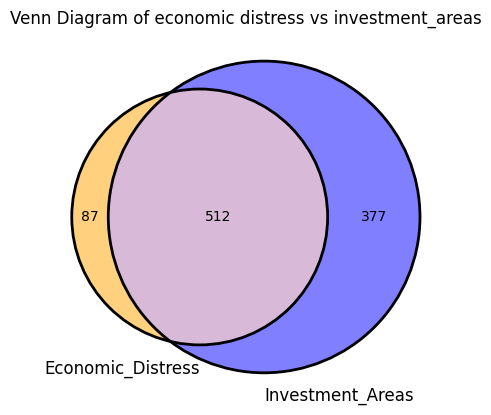

In [ ]:
ctf=pd.crosstab(df2.economic_distress_pop_agg,df2.investment_areas)
# depict venn diagram
subsets = (ctf[0][1], ctf[1][0], ctf[1][1])
venn2(subsets,
      set_labels = ('Economic_Distress',
                    'Investment_Areas'),
      set_colors=("orange",
                  "blue"),alpha=0.5)

# add outline
venn2_circles(subsets)
# assign title of the venn diagram
plt.title("Venn Diagram of economic distress vs investment_areas")
plt.show()


Useful resource for plotting Venn diagrams:
https://www.geeksforgeeks.org/how-to-create-and-customize-venn-diagrams-in-python/#

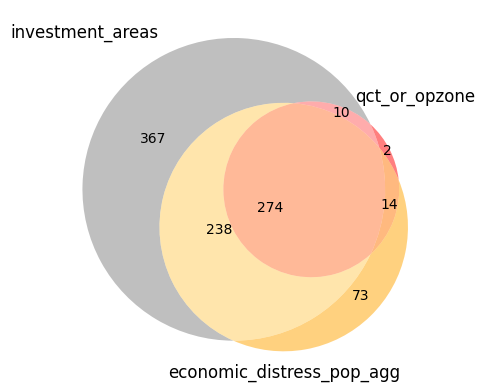

In [ ]:
# create venn diagram without crosstab

setI=set(df2[df2.investment_areas==1].geoid.values)
setEP=set(df2[df2.economic_distress_pop_agg==1].geoid.values)
setES=set(df2[df2.economic_distress_simple_agg==1].geoid.values)

setQ=set(df2[df2.qct==1].geoid.values)
setOP=set(df2[df2.opzone==1].geoid.values)
#venn2((set1, set2), ('investment_areas', 'economic_distress_pop_agg'),set_colors=("blue",
#                  "orange"),alpha=0.5)
#venn3((setI, setEP, setES), ('investment_areas', 'economic_distress_pop_agg','economic_distress_simple_agg'),set_colors=("blue",
#                  "orange","red"),alpha=0.5)
#venn3((setI,setQ,setOP),('investment_areas','qct','opzone'),set_colors=("blue","green","red"),alpha=0.5)
setM=set(df2.query("qct==1 or opzone==1").geoid.values)
venn3((setI,setM,setEP),('investment_areas', 'qct_or_opzone','economic_distress_pop_agg'),set_colors=("grey","red","orange"),alpha=0.5)
plt.show()
#set2

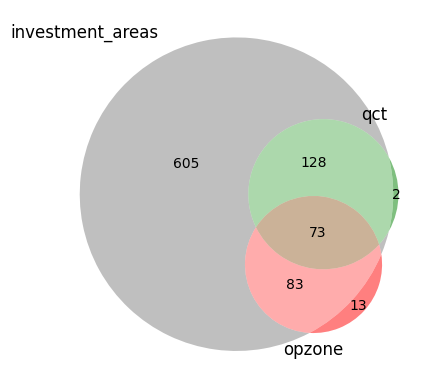

In [ ]:
venn3((setI,setQ,setOP),('investment_areas','qct','opzone'),set_colors=("grey","green","red"),alpha=0.5)
#venn3_circles(subsets=(setI,setQ,setOP),
#              linestyle="dashed", linewidth=2)
plt.show()

## How do populations vary by program?
https://docs.kanaries.net/topics/Pandas/pandas-plot-histogram

https://eodatascape.datakind.org/data-dictionary

TODO:
* add titles to plotly radial graphs:
fig.update_layout(title="My Plot Title")
* figure out how to plot multiple figures as subplots
* include the graphs that are unfiltered, and include commentary about why filtering as we are
* how to get population/population density?  
* would be interesting to know what proportion of needy people live in HUD areas overall and by demographics (age, race etc)


### Distribution Comparisons via Plotly Scatterpolar

#### define helper functions for computing and plotting quantiles
*Must run this cell to be able to generate plots in this section*

In [32]:
#define helper functions to generate and plot quantilies
import plotly.graph_objects as go

# import plotly.offline as pyo # trying to get plotly to work in Jupyter nbviewer

"""
# try this to see if will work to make plotly visible in Git
import plotly.io 2 as pio
pio.renderers.default = “notebook_connected+colab”
"""

# fillOptions are: "none", "toself", and "tonext", for plotly scatterpolar
# line options are: 'solid' : Solid line, 'dash': Dashed line, 'dashdot': Dash-dot line, 'longdash': Long dashed line, and 'longdashdot': Long dash-dot line.
my_quantiles_styled={
    0.25: ["25th","dash","none"],
    0.75: ["75th","dash","tonext"],
    0.5: ["50th","solid","none"],
    0.9: ["90th","dash","none"],
    1.0: ["100th","dot","none"],
}

my_gov_programs_dict={
    "investment_areas" : {"filter" : "investment_areas=='YES'", "color":"red","legend_prefix":"investment area:"},
    "opzone" : {"filter" : "opzone==1", "color":"green", "legend_prefix" : "HUD opzone:"},
    "qct" : {"filter" : "qct==1", "color":"purple", "legend_prefix":"HUD qct:"},
}


# returns a dataframe with quantiles, given:
#   an input dataframe,
#   a dictionary of columns to compute quantiles for,
#      with key=column name in dataframe, value=name to use in plots
#   an optional row filter string to apply before computing quantiles
def make_quantiles(ldf,desired_columns_dict,row_filter_str=None):
  f = [*desired_columns_dict][0]+">=0" # have this to remove rows with negative/error values, though this is dodgy for some columns..
#  print("excluding ", ldf.query(desired_columns[0]+"<0").iloc[:,0].count()," rows with negative values in first column")
  if (row_filter_str):
    f += " and ("+row_filter_str+")"
  q = ldf.query(f).loc[:,[*desired_columns_dict]].quantile([*my_quantiles_styled]) # fancy way of saying list(my_quantiles_styled.keys())
  return q.rename(columns=desired_columns_dict)

# returns a dict of quantile dataframes, on per government program type
def make_quantiles_by_gov_program(ldf,desired_columns_dict,row_filter_str=None):
  qdict={}
  for k,v in my_gov_programs_dict.items():
#    print("making quantiles for ",k)
    fstr=v["filter"]
    if (row_filter_str):
      fstr += " and ("+row_filter_str+")"
    qdict[k]=make_quantiles(ldf,desired_columns_dict,fstr)
  return qdict

# returns a figure with a trace added per quantile
def plot_quantiles(fig,quantiles,mycolor="blue",desired_range_max=100,name_prefix=""):
  for i in quantiles.index:
    fig.add_trace(go.Scatterpolar(
        r=quantiles.loc[i,:],
        theta=quantiles.columns,
        fill=my_quantiles_styled[i][2],
        name=name_prefix+my_quantiles_styled[i][0],
        mode='lines+markers',
        line=dict(color=mycolor, width=2, dash=my_quantiles_styled[i][1])
    ))
  fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, desired_range_max]
        )),
      showlegend=True
  )
  return fig

# returns a figure with a trace added per quantile
def plot_quantiles_by_gov_program(fig,gov_program_df_dict,desired_range_max=100,limit_rows=[],limit_cols=[]):
  for k,v in gov_program_df_dict.items():
    v2=v
    if (len(limit_rows)>0):
      v2=v2.loc[limit_rows,:]
    if (len(limit_cols)>0):
      v2=v2.loc[:,limit_cols]
    fig = plot_quantiles(fig,v2,my_gov_programs_dict[k]["color"],desired_range_max,my_gov_programs_dict[k]["legend_prefix"])
  return fig


#### Looking at racial demographics

In [33]:

# keyed by column name, value is name to use when plotting
racial_diversity_columns_dict={
    "dp05_0035pe" : "multi",
    "dp05_0037pe" : "white",
    "dp05_0038pe" : "black",
    "dp05_0044pe" : "asian",
    "dp05_0052pe" : "hawaiian or pacific islander",
    "dp05_0039pe" : "native american",
    "dp05_0057pe" : "other",
}

racial_quantiles=make_quantiles(df,racial_diversity_columns_dict)
gov_rqd=make_quantiles_by_gov_program(df,racial_diversity_columns_dict)


fig = go.Figure()

# limiting the set of quantiles and races for readability
fig = plot_quantiles(fig,racial_quantiles.loc[[0.5,0.9],["white","black","multi"]],"blue",100,"all:")
fig = plot_quantiles_by_gov_program(fig,gov_rqd,100,[0.5,0.9],["white","black","multi"])
fig.update_layout(
  title="Racial distribution in census tracts by government housing program. 50th and 90th percentile",
)

fig.show()
#pyo.iplot(fig) #trying to get to show up in Jupyter nbviewer


In [ ]:
df.query("s1701_c03_014e==100").loc[:,poverty_race_columns].head()

,s1701_c03_019e,s1701_c03_013e,s1701_c03_021e,s1701_c03_014e,s1701_c03_020e
11,15.6,1.8,1.9,100.0,11.3
21,35.3,5.3,5.4,100.0,0.0
178,6.1,9.3,9.4,100.0,9.6
181,46.5,14.5,13.5,100.0,18.0
211,0.0,10.9,10.9,100.0,-666666666.0


In [34]:

poverty_race_columns_dict={
    "s1701_c03_019e" : "multi",
    "s1701_c03_013e" : "white",
    "s1701_c03_021e" : "white non-hispanic",
    "s1701_c03_014e" : "black",
    "s1701_c03_020e": "hispanic any race",
}

poverty_race_quantiles=make_quantiles(df,poverty_race_columns_dict)
gov_prqd=make_quantiles_by_gov_program(df,poverty_race_columns_dict)


fig = go.Figure()
# limiting set of races to show for readability, due to redundancy
cols=["white non-hispanic","black","multi"]

fig = plot_quantiles(fig,poverty_race_quantiles.loc[[0.5,0.9],cols],"blue",80,"all:")
fig = plot_quantiles_by_gov_program(fig,gov_prqd,80,[0.5,0.9],cols)

fig.show()
#pyo.iplot(fig) #trying to get to show up in Jupyter nbviewer

In [ ]:

fig = go.Figure()
fig = plot_quantiles(fig,racial_quantiles,"blue")
fig.show()

#### experiments with plotly violin and histogram plots

In [ ]:
# "share_of_properties_at_risk_of_flood_in_30_years"

pd.options.plotting.backend = "plotly"

dff=df.loc[:,[
    "geoid",
    "share_of_properties_at_risk_of_flood_in_30_years",
    "share_of_properties_at_risk_of_flood_in_30_years_percentile",
    "investment_areas",
    "qct",
    "opzone"
    ]]

dff.plot.hist(y="share_of_properties_at_risk_of_flood_in_30_years",bins=10,histnorm='percent',marginal="violin", # can be 'rug', `box`, `violin`
              hover_data=dff.columns)

In [ ]:

#https://plotly.com/python/violin/


fig = px.violin(dff, y="share_of_properties_at_risk_of_flood_in_30_years", color="qct", box=True, points="all", violinmode='overlay',
          hover_data=dff.columns)

#fig.add_trace(px.violin(dff, y="share_of_properties_at_risk_of_flood_in_30_years", color="opzone", box=True, points="all", violinmode='overlay',
#          hover_data=dff.columns))

fig.show()

### Geospatial visualizations


This section is under construction!  Am using Folium to create interactive maps showing which government programs different census tracts belong to, filtered in arbitrary ways.  Also want to add layers for things like environmental hazards, racial composition etc

In [ ]:
# perhaps I should be using 2020 or 2022 data instead? Not sure
url="https://github.com/kodiakpony/datakit-housing-fall-2024/raw/refs/heads/main/challenge-3/FL/cb_2023_12_tract_500k.zip"
gdf = gpd.read_file(url)
gdf["geoid"]=gdf["GEOID"].astype(int)
gdf.set_index("geoid", inplace=True)

merged_gdf = gdf.merge(df2, on='geoid')
#merged_gdf.columns

In [ ]:

merged_gdf2=merged_gdf
merged_gdf2["geometry"] = merged_gdf2.centroid
#merged_gdf2=merged_gdf2.set_geometry("centroid")

#merged_gdf2.plot()
#merged_gdf2.head().T

<ipython-input-49-011210f41dc1>:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [ ]:
import folium

# @title This cell creates a Folium map with markers colored by gov program and filtered by query string, with tooltips and popups { run: "auto" }

filter_string = "county==31 and investment_areas==1" # @param ["NAMELSADCO=='Marion County'", "investment_areas==0 and (opzone==1 or qct==1)", "county==31 and investment_areas==1"] {allow-input: true}
#filter_string="NAMELSADCO=='Marion County'"
#filter_string="investment_areas==0 and (opzone==1 or qct==1)" #county==31" # and investment_areas==1"
# let's try using GeoJSON instead of chloropleth
#filter_string = "opzone==1 and qct==1 and county==31"

merged_gdf = gdf.merge(df2, on='geoid')
#merged_gdf = gdf.merge(data, on='unique_id_column')

# Create a base map
#ctr=merged_gdf.geometry.centroid
#center_latitude=(ctr.y.max()+ctr.y.min())/2
#center_longitude=(ctr.x.max()+ctr.x.min())/2
#center_longitude=(merged_gdf.geometry.centroid.x.mean()
m = folium.Map(#location=[center_latitude, center_longitude],
#               zoom_start=7,
               min_zoom=6,
               tiles="cartodb positron"
               )

popup = folium.GeoJsonPopup(
    fields=["NAMELSADCO", "NAMELSAD", "opzone", "qct", "investment_areas"],
    aliases=["County:", "Tract:", "is HUD Opporunity Zone:", "Is HUD Qualified Census Tract:","is Investment Area:"],
    localize=True,
    labels=True,
    style="background-color: yellow;",
)


tooltip = folium.GeoJsonTooltip(
    fields=["NAMELSADCO", "NAMELSAD", "opzone", "qct", "investment_areas"],
    aliases=["County:", "Tract:", "is HUD Opporunity Zone:", "Is HUD Qualified Census Tract:","is Investment Area:"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    max_width=800,
)

# style_function parameters: https://leafletjs.com/reference.html#path-option


#You can use: ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen',
# 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray'] i
# con_color (str, default 'white') – The color of the drawing on the marker.


merged_gdf2=merged_gdf.query(filter_string)
merged_gdf2["geometry"] = merged_gdf2.centroid
#merged_gdf2["geometry"] = merged_gdf2.centroid
#merged_gdf2=merged_gdf2.set_geometry("centroid")
folium.GeoJson(
    merged_gdf2,
    zoom_start=7,
    min_zoom=7,

#    marker=folium.CircleMarker(radius=4, fill_color="orange", fill_opacity=0.4, color="orange", weight=1),
    marker=folium.Marker(icon=folium.Icon(icon='star')),
#    marker=folium.Marker(),
    style_function=lambda feature: {
      "fillColor": "green"
      if feature["properties"]["opzone"]==1
      else "#ffff00",
      "color": "green"
      if feature["properties"]["opzone"]==1
      else "#ffff00",
      "markerIcon": "info-sign",
      "markerIconColor": "green",
      "markerColor": "lightgray"
      if feature["properties"]["opzone"]==0 and feature["properties"]["qct"]==0 and feature["properties"]["investment_areas"]==0
      else (
        "beige" if feature["properties"]["opzone"]==0 and feature["properties"]["qct"]==0 and feature["properties"]["investment_areas"]==1
        else (
            "purple" if feature["properties"]["opzone"]==1 and feature["properties"]["qct"]==1 and feature["properties"]["investment_areas"]==1
            else (
                "blue" if feature["properties"]["opzone"]==1 and feature["properties"]["qct"]==0 and feature["properties"]["investment_areas"]==1
                else (
                    "green" if feature["properties"]["opzone"]==0 and feature["properties"]["qct"]==1 and feature["properties"]["investment_areas"]==1
                    else (
                        "darkpurple" if feature["properties"]["opzone"]==1 and feature["properties"]["qct"]==1 and feature["properties"]["investment_areas"]==0
                        else (
                            "darkblue" if feature["properties"]["opzone"]==1 and feature["properties"]["qct"]==0 and feature["properties"]["investment_areas"]==0
                            else (
                                "darkgreen" if feature["properties"]["opzone"]==0 and feature["properties"]["qct"]==1 and feature["properties"]["investment_areas"]==0
                                else "red"
                            )
                        )
                    )
                )
            )
        )
      ),

#      else "blue",
#      if feature["properties"]["investment_areas"]==1 and feature["properties"]["qct"]==0 and feature["properties"]["opzone"]==0

 #     "show": True
 #     if feature["properties"]["opzone"]==1
 #     else False,
#      "show": False,
      "weight": 1,
      "radius": 4,
#      "markerOpacity": 0.2,
#      "fillOpacity": 0.2,
#      "dashArray": "5, 5",
    },
#    style_function=lambda x: {
#        "fillColor": colors[x['properties']['service_level']],
#        "radius": (x['properties']['lines_served'])*30,
#    },
    popup_keep_highlighted=True,
    highlight_function=lambda x: {"fillOpacity": 0.8},
#    highlight=True,  # highlight doesn't seem to exist, but highlight_function and popup_keep_highlighted do
    tooltip=tooltip,
    popup=popup,
    zoom_on_click=True,
    #      if "e" in feature["properties"]["NAMELSADCO"].lower()
).add_to(m)

# Add a layer control
folium.LayerControl().add_to(m)

# Pan and Zoom map starting position to include overlays
folium.FitOverlays().add_to(m)

# Display the map
m



<ipython-input-57-90d4eb1bc7f8>:58: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#@title This creates a Folium Chloropleth map with a layer per government housing program, no popups
import folium

# Load GeoDataFrame
#gdf = gpd.read_file('your_geospatial_data.geojson')

# Load data
#data = pd.read_csv('your_data.csv')

merged_gdf = gdf.merge(df2, on='geoid')
#merged_gdf = gdf.merge(data, on='unique_id_column')

# Create a base map
ctr=merged_gdf.geometry.centroid
center_latitude=(ctr.y.max()+ctr.y.min())/2
center_longitude=(ctr.x.max()+ctr.x.min())/2
#center_longitude=(merged_gdf.geometry.centroid.x.mean()
m = folium.Map(location=[center_latitude, center_longitude],
               zoom_start=7,
               min_zoom=7,
               tiles="cartodb positron"
               )
#m=folium.Map()

# Create the Investment Areas choropleth layer
folium.Choropleth(
    geo_data=merged_gdf[merged_gdf.investment_areas==1],
    name='Investment Areas',
    fill_color='#aaaaff',
    fill_opacity=0.5,
    line_opacity=0.2,
    highlight=True,

#    legend_name='Investment Areas'
).add_to(m)

# Create the HUD Qualfied Census Tract choropleth layer
folium.Choropleth(
    geo_data=merged_gdf[merged_gdf.qct==1],
    name='HUD Qualified Census Tracts',
#    data=merged_gdf[merged_gdf.qct==1],
 #   columns=['unique_id_column', 'value_column'],
#    columns=['geoid','qct'],
#    key_on='feature.properties.geoid',
#    fill_color='YlGnBu',
    fill_color="red",
    fill_opacity=0.5,
    line_opacity=0.2,
    highlight=True,
    legend_name='Qualified Census Tracts'
).add_to(m)


# Create the HUD opportunity zones choropleth layer
folium.Choropleth(
    geo_data=merged_gdf[merged_gdf.opzone==1],
    name='HUD Opportunity Zones',
    fill_color='yellow',
    fill_opacity=0.5,
    line_opacity=0.2,
    highlight=True,
    legend_name='Opzone',

).add_to(m)


# Add a layer control
folium.LayerControl().add_to(m)

# Display the map
m


<ipython-input-55-7f2a95f1bd82>:14: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




### works in progress / scratch space

In [ ]:
df3=df2.set_index("geoid", inplace=False, drop=False)
df3

,geoid,county,opzone,investment_areas,qct,economic_distress_pop_agg,economic_distress_simple_agg
geoid,,,,,,,
12001000400,12001000400,1,1,1,0,1,1
12001000806,12001000806,1,0,1,1,1,1
12001000901,12001000901,1,0,1,1,1,1
12001001203,12001001203,1,0,1,0,1,1
12001001514,12001001514,1,0,1,1,1,1
...,...,...,...,...,...,...,...
12033003506,12033003506,33,0,1,1,0,0
12033003800,12033003800,33,0,0,0,0,0
12033003900,12033003900,33,0,0,0,0,0


In [ ]:
gdf["investment_areas"]=df3["investment_areas"]


<Axes: >

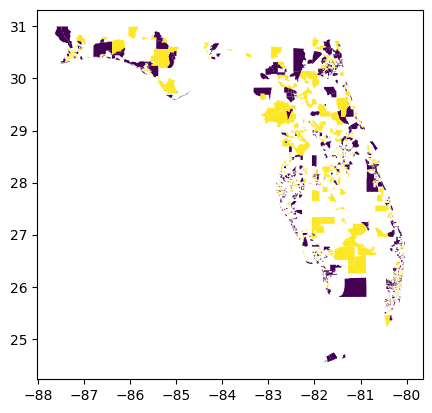

In [ ]:
gdf.plot("investment_areas")

<Axes: >

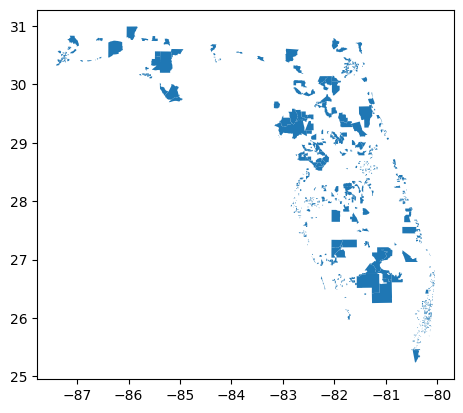

In [ ]:
gdf[gdf["investment_areas"] == 1 ].plot()

<Axes: >

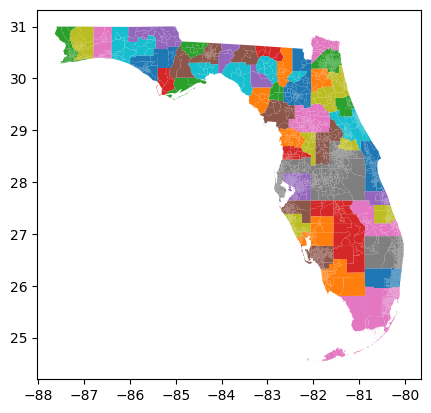

In [ ]:
gdf.plot("COUNTYFP")

<Axes: >

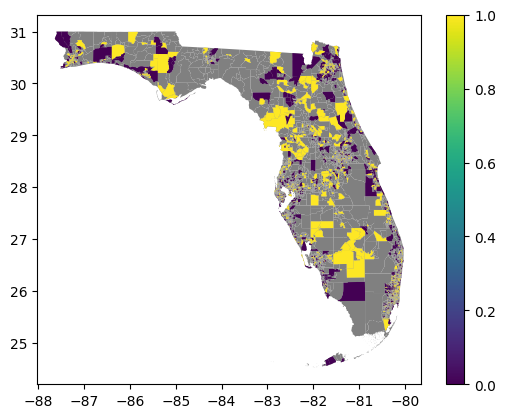

In [ ]:
ax=gdf.plot(color="grey")
gdf.plot("investment_areas",legend="true",ax=ax)
#gdf.plot("investment_areas",legend="true")

In [ ]:
df_silly=df.set_index("geoid",drop=False,inplace=False)
gdf["share_of_properties_at_risk_of_flood_in_30_years"]=df_silly["share_of_properties_at_risk_of_flood_in_30_years"]
gdf["share_of_properties_at_risk_of_flood_in_30_years_percentile"]=df_silly["share_of_properties_at_risk_of_flood_in_30_years_percentile"]

<Axes: >

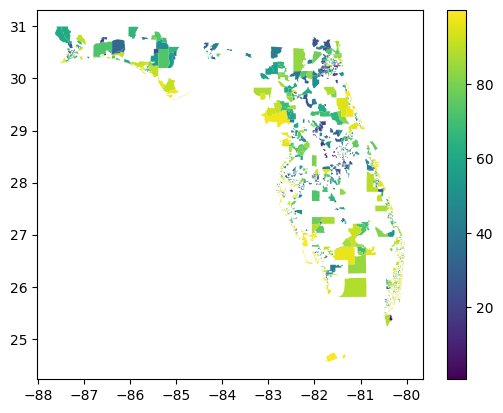

In [ ]:
gdf.plot("share_of_properties_at_risk_of_flood_in_30_years_percentile",legend=True,cmap="viridis")

<Axes: >

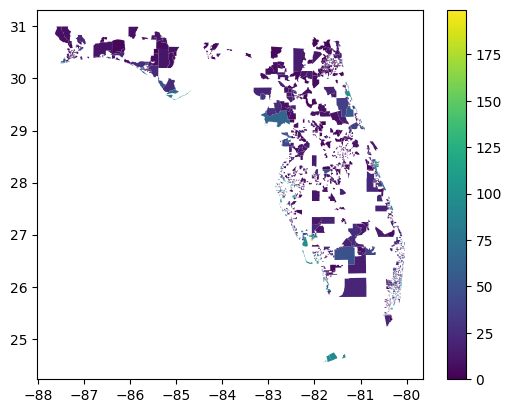

In [ ]:
gdf.plot("share_of_properties_at_risk_of_flood_in_30_years",legend=True)

In [ ]:
gdf[["share_of_properties_at_risk_of_flood_in_30_years","share_of_properties_at_risk_of_flood_in_30_years_percentile"]].describe()

,share_of_properties_at_risk_of_flood_in_30_years,share_of_properties_at_risk_of_flood_in_30_years_percentile
count,1596.000000,1596.000000
mean,23.854170,68.000741
std,27.785674,28.767089
min,0.000000,0.663973
25%,5.000000,43.349142
50%,12.765434,77.725277
75%,30.972976,93.519820
max,199.000000,99.992974


### The mystery of the missing geoids

Uh-oh!   There is a mystery here.  My GeoDataFrame only has 1596 investment_areas, but my original dataframe had 1605.  I think that means there are some geoids in the original dataframe that don't appear in my geo one.  Maybe that's because I got my data from 2023?  Need to sort this out, but am ignoring for now.  

I did confirm that none of these missing geoids are investment areas, qcts, in economic distress etc

**DOH! It turned out the missing geoids were a mistake in the initial dataset provided byDataKind folks. Will see what happens when get an updated dataset.**

In [ ]:
# display data for geoids that appear in original dataframe but not in the geo dataframe. It looks like none of these are interesting
df3["gdgeoid"]=gdf["GEOID"].astype(int)
df3[df3["gdgeoid"].isna() == True]

,geoid,county,opzone,investment_areas,qct,economic_distress_pop_agg,economic_distress_simple_agg,gdgeoid
geoid,,,,,,,,
12029990000,12029990000,29,0,0,0,0,0,NaN
12033990000,12033990000,33,0,0,0,0,0,NaN
12037990100,12037990100,37,0,0,0,0,0,NaN
12075990000,12075990000,75,0,0,0,0,0,NaN
12085990000,12085990000,85,0,0,0,0,0,NaN
12091990100,12091990100,91,0,0,0,0,0,NaN
12115990000,12115990000,115,0,0,0,0,0,NaN
12009990000,12009990000,9,0,0,0,0,0,NaN
12031990000,12031990000,31,0,0,0,0,0,NaN


In [ ]:
df2.describe()

,geoid,county,opzone,investment_areas,qct,economic_distress_pop_agg,economic_distress_simple_agg
count,1.605000e+03,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000
mean,1.206093e+10,60.847975,0.105919,0.553894,0.127103,0.373209,0.413707
std,3.905234e+07,39.039983,0.307830,0.497242,0.333192,0.483808,0.492651
min,1.200100e+10,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.201903e+10,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.207100e+10,71.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.209704e+10,97.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.213397e+10,133.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#Appendix


## TODO

* can I filter the set of markers shown in Folium Map, still using a dataframe?  If so, filter by Government program, county, freeform?
* decide whether I want separate layers per government program (can I make programs translucent?  depends a bit on answer to filtering question
* figure out how to show plots in a popup / separate pane based on selected geoid
* experiment with coloring markers by flood risk / other environmental hazards
* figure out how to make histograms overlaid with value for particular geoid. Or just show percentile of geoid relative to others?
* decide which things I want to have as markers vs polygons vs boundaries

### Interactive plots

From AI summary:

Choosing the right option:

For quick interactive plots: Use the Plotly backend.
looks nice!
https://plotly.com/python/basic-charts/


For a visual interface: Use PandasGUI.

For custom interactivity: Use Matplotlib and ipywidgets.

For advanced visualizations: Use Altair.

In [ ]:
import pandas as pd
pd.options.plotting.backend = "plotly"

df = pd.DataFrame({'x': [1, 2, 3], 'y': [4, 5, 6]})
df.plot(kind='scatter', x='x', y='y')

In [ ]:
!pip install pandasgui

In [ ]:
import os

# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import pandas as pd



from google.colab import drive
drive.mount('/content/drive')

df = pd.DataFrame({'x': [1, 2, 3], 'y': [4, 5, 6]})
show(df)

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact

df = pd.DataFrame({'x': [1, 2, 3], 'y': [4, 5, 6]})

@interact(kind=['line', 'bar', 'scatter'])
def plot_df(kind):
    df.plot(kind=kind)
    plt.show()

interactive(children=(Dropdown(description='kind', options=('line', 'bar', 'scatter'), value='line'), Output()…

In [ ]:
import pandas as pd
import altair as alt

df = pd.DataFrame({'x': [1, 2, 3], 'y': [4, 5, 6]})

alt.Chart(df).mark_point().encode(
    x='x',
    y='y'
).interactive()

alt.Chart(...)

## Newbie notes


data dictionary:
https://eodatascape.datakind.org/data-dictionary

Some nice examples of interactive tools looking at similar data:
https://www.energy.gov/scep/slsc/lead-tool
https://justice40.cnt.org/
both use MapBox
MapBox vs GoogleMaps:
https://medium.com/@support_74363/mapbox-vs-google-maps-what-are-the-differences-web-developers-leicester-49518132c40b#:~:text=The%20quality%20of%20geographic%20data,terms%20of%20accuracy%20and%20coverage.

methodology for flood risk columns
https://screeningtool.geoplatform.gov/en/methodology#flood-risk

Some useful references for python zip file csv reading:

https://docs.python.org/3/library/zipfile.html

https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

https://www.geeksforgeeks.org/with-statement-in-python/

other basic Python things:

https://www.geeksforgeeks.org/python-get-dictionary-keys-as-a-list/


Useful resource for plotting Venn diagrams: https://www.geeksforgeeks.org/how-to-create-and-customize-venn-diagrams-in-python/#

Am currently trying to find a map of census tracts to load to be able to visualize data geographically.

Have spent way too long trying to figure this out! I think the right place to get data is from census.gov. I found a useful description of geoids here:

https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html

and a way to download TIGER files here:

https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html

https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html


and some promising looking tutorials and Q&A here:

https://geopandas.org/en/stable/getting_started/introduction.html

https://medium.com/@jl_ruiz/plot-maps-from-the-us-census-bureau-using-geopandas-and-contextily-in-python-df787647ef77

https://stackoverflow.com/questions/76369026/how-to-access-us-census-tiger-shapefiles-in-geopandas

https://www.natekratzer.com/posts/census_map/

So hopefully between those and the example someone else already did for DataKit, I can figure this out! Still plugging away, though.

Dealing with GIT:

https://docs.github.com/en/pull-requests/collaborating-with-pull-requests/proposing-changes-to-your-work-with-pull-requests/creating-a-pull-request

GIS software:

https://gisgeography.com/arcgis-pro-vs-qgis-3/
https://gisgeography.com/qgis2web/
https://gisgeography.com/web-mapping/
https://gisgeography.com/qgis-cloud/
https://gisgeography.com/gis-programming-tutorials/

GeoPandas:
https://github.com/tobah59x/GeoPandasCPJ


Folium:

https://python-visualization.github.io/folium/latest/user_guide/geojson/choropleth.html
https://python-visualization.github.io/folium/latest/reference.html
https://python-visualization.github.io/folium/latest/reference.html#module-folium.features

https://leaflet-extras.github.io/leaflet-providers/preview/
https://medium.com/datasciencearth/map-visualization-with-folium-d1403771717

https://python-visualization.github.io/folium/latest/advanced_guide/colormaps.html
https://python-visualization.github.io/folium/latest/user_guide/geojson/geopandas_and_geo_interface.html

https://github.com/datakind/datakit-housing-fall-2024/blob/main/challenge-4/racehd/FL-disaster-vulnerabilities.ipynb


Supported marker colors:
You can use: ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray'] icon_color (str, default 'white') – The color of the drawing on the marker.


Hacktoberfest:

https://hacktoberfest.com/profile/

Plotly interactive charts:

https://plotly.com/python/basic-charts/
Radar charts and violin charts seem cool.
https://plotly.com/python/radar-chart/


Manual inputs to Notebook via dropdowns, text boxes etc forcing recompute:

https://colab.research.google.com/notebooks/forms.ipynb

Looks like need to use IPWidgets to have dropdown with list of entries created at runtime (e.g. counties in Florida based on dataset).
With Google Forms it looks like changing value forces cell to recompute if you have something like this in the cell:

# @title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }

 Not sure if can get the same with IPWidgets. Doing the same thing doesn't work for IPWidgets. Also not sure if there is a way to get multiple cells to recompute


